# Deep Learning with PyTorch : Build an AutoEncoder

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
%cd /content/drive/MyDrive/Projects/Pytorch/Auto Encoder with MNIST

/content/drive/MyDrive/Projects/Pytorch/Auto Encoder with MNIST


An autoencoder is a type of neural network that learns to copy its input to its output. In autoencoder, encoder encodes the image into compressed representation, and the decoder decodes the representation.

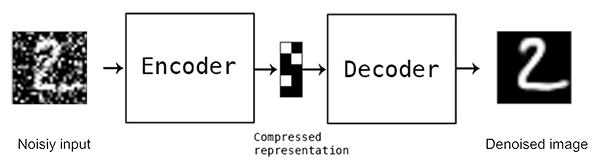

Applications of AutoEncoder:

- Segmentation
- Denoising Image
- Super Resolution Image
- Image Compression
- and many more .....

In this Project, you will see the simplest implemention of autoencoder for image denoising task.

In [3]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 

# Exploring Dataset 

In [4]:
data = pd.read_csv("mnist_dataset.csv")
data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Select image at index 3
image = data.iloc[3]
image = np.array(image).astype("float32")

# Reshape image
image = np.reshape(image, (28, 28))

# Scale image (0 - 1)
image = image / 255 

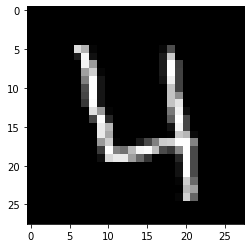

In [6]:
# Plot the image
plt.imshow(image, cmap = "gray")

In [9]:
noisy_image = image + 0.2 * np.random.randn(*image.shape)
noisy_image = np.clip(noisy_image, 0, 1)

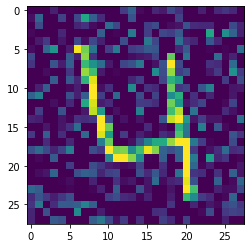

In [10]:
plt.imshow(noisy_image)

# Data Preparation 

Here to `ToTensorForAE()` is a custom transform which will convert numpy, PIL image to torch tensor and also it will convert image with (height, width, channel) to (channel, height, width) as per the pytorch model input convention.

In [13]:
import matplotlib.pyplot as plt 
import numpy as np 
import torch


def show_image(noisy_image,org_image,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('noisy_image')
        ax1.imshow(noisy_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('original_image')
        ax2.imshow(org_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('noisy_image')
        ax1.imshow(noisy_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('original_image')
        ax2.imshow(org_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('denoised_image')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        
class ToTensorForAE(object):
    
    def __call__(self,sample):
        
        images,labels = sample
        
        images = images.transpose((2,0,1))
        labels = labels.transpose((2,0,1))
        
        return torch.from_numpy(images).float(),torch.from_numpy(labels).float()


In [30]:
### Load data

class MNIST_AE_Dataset(Dataset):

  def __init__(self, csv_file, noise_factor = 0.2, transform = None):

    self.data = pd.read_csv(csv_file)
    self.noise_factor = noise_factor
    self.transform = transform

  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    img = self.data.iloc[idx]
    img = np.array(img)
    img = np.reshape(img, (28, 28, 1))
    img = img / 255.

    noisy_img = img + self.noise_factor * np.random.rand(*img.shape)
    noisy_img = np.clip(noisy_img, 0, 1)

    sample = (noisy_img, img)

    if self.transform:
      sample = self.transform(sample)

    return sample

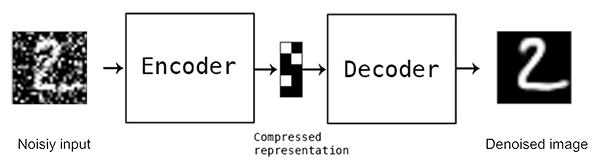

For eg, numpy array image with shape (28, 28, 1) will be first converted to image torch tensor with shape(28, 28, 1)
and then the channel is shifted to 0th axis so image tensor will be with shape (1, 28, 28)

In [31]:
trainset = MNIST_AE_Dataset('mnist_dataset.csv', transform = ToTensorForAE())

In [32]:
print("Size of trainset: {}".format(len(trainset)))

Size of trainset: 42000


In [33]:
trainset[1]

(tensor([[[1.1710e-01, 1.5352e-02, 6.3987e-02, 1.2203e-01, 1.4243e-01,
           1.6421e-01, 1.8020e-01, 1.9165e-01, 1.4188e-01, 6.1422e-02,
           3.0257e-02, 6.3929e-02, 1.3797e-01, 1.9624e-01, 1.0058e-01,
           1.2426e-01, 7.1565e-02, 2.7390e-02, 9.8151e-02, 1.1348e-01,
           1.5328e-01, 4.9645e-02, 2.4359e-02, 5.8498e-02, 7.0018e-02,
           1.1099e-01, 1.6476e-01, 4.3196e-03],
          [1.3796e-01, 1.0224e-01, 1.9789e-01, 1.6758e-01, 1.7210e-01,
           4.7824e-02, 5.1370e-03, 3.4072e-02, 1.3362e-01, 1.9183e-01,
           8.2457e-02, 6.9645e-02, 5.0057e-02, 1.1592e-01, 1.8565e-01,
           1.2635e-02, 4.3267e-02, 1.1125e-01, 3.6218e-02, 1.7683e-01,
           6.3511e-02, 1.3640e-01, 1.4997e-01, 3.1098e-02, 2.2875e-02,
           1.0452e-02, 1.5288e-01, 6.1691e-02],
          [8.2420e-02, 8.9915e-02, 1.9016e-01, 2.3707e-02, 9.4139e-02,
           1.3725e-01, 7.7147e-02, 3.3571e-02, 3.6455e-02, 1.7039e-01,
           4.1569e-02, 1.9805e-01, 1.1144e-01, 1.435

In [34]:
noisy_img, org_img = trainset[32]

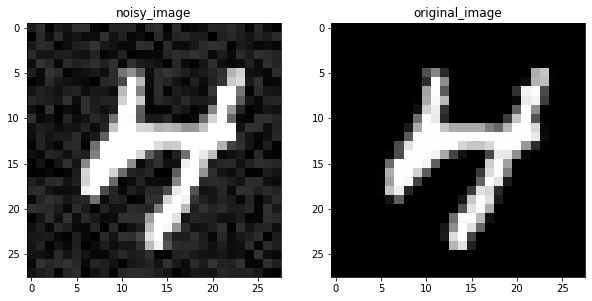

In [35]:
show_image(noisy_img, org_img)

# Load dataset into batches

In [37]:
from torch.utils.data import DataLoader 
trainloader = DataLoader(trainset, batch_size = 16, shuffle = True)

In [38]:
dataiter = iter(trainloader)

noisy_img, org_img = dataiter.next()

print("Shape of loading one batch: {}".format(noisy_img.shape))

print("Total no. of batches: {}".format(len(trainloader))) # Number of batches

print("Total no. of examples: {}".format(len(trainloader.dataset)))

Shape of loading one batch: torch.Size([16, 1, 28, 28])
Total no. of batches: 2625
Total no. of examples: 42000


# Create AutoEncoder Model


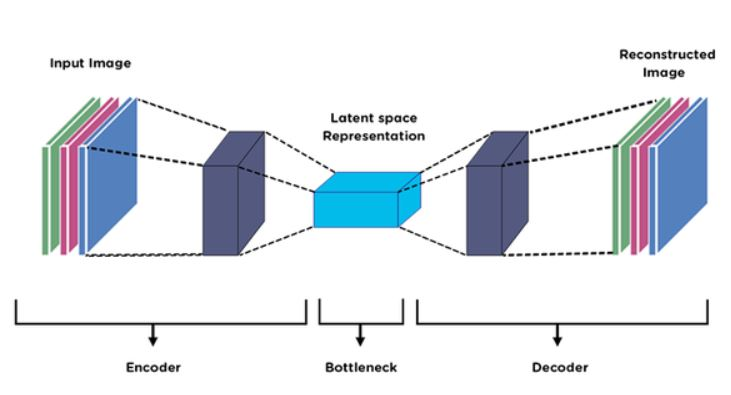

In [39]:
from torch import nn
from torchsummary import summary

In [53]:
def Encoder():

  enc = nn.Sequential(
      nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = (3, 3), padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = (2, 2)),
      nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3, 3), padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = (2, 2))
  )

  return enc

In [54]:
def Decoder():

  dec = nn.Sequential(
      nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = (2, 2), stride = 2),
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=16, out_channels = 1, kernel_size = (2, 2), stride = 2),
      nn.Sigmoid()
  )

  return dec

In [55]:
class AutoEncoder(nn.Module):

  def __init__(self):
    super(AutoEncoder, self).__init__()

    self.encoder = Encoder()
    self.decoder = Decoder()
  
  def forward(self, input_imgs):

    encoder_out = self.encoder(input_imgs)
    decoder_out = self.decoder(encoder_out)

    return decoder_out

model = AutoEncoder()
model

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [56]:
summary(model, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
   ConvTranspose2d-7           [-1, 16, 14, 14]           2,064
              ReLU-8           [-1, 16, 14, 14]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]              65
          Sigmoid-10            [-1, 1, 28, 28]               0
Total params: 6,929
Trainable params: 6,929
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.03
Estimated Total

# Train AutoEncoder Model 

In [58]:
from tqdm import tqdm
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()
epochs = 10

In [59]:
for i in range(epochs):
  train_loss = 0.0

  for batch in trainloader:
    noisy_img, org_img = batch

    denoised_img = model(noisy_img)
    loss = criterion(denoised_img, org_img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  avg_loss = train_loss / len(trainloader)

  print("Epoch: {} | Train loss: {}".format(i + 1, avg_loss))

Epoch: 1 | Train loss: 0.012005486233248597
Epoch: 2 | Train loss: 0.004150482875871516
Epoch: 3 | Train loss: 0.003673110855876335
Epoch: 4 | Train loss: 0.00337963011470579
Epoch: 5 | Train loss: 0.0032056846333046755
Epoch: 6 | Train loss: 0.0030884517695577373
Epoch: 7 | Train loss: 0.0030020295369571873
Epoch: 8 | Train loss: 0.002931167190229254
Epoch: 9 | Train loss: 0.002880145684948989
Epoch: 10 | Train loss: 0.0028351061456348926


# Plot Results

torch.Size([1, 28, 28])


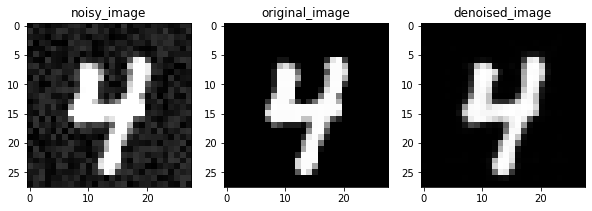

In [64]:
model.eval()
with torch.no_grad():

  dataiter = iter(trainloader)
  sample = dataiter.next()

  noisy_img, org_img = sample

  index = 2

  denoised_img = model(noisy_img[index].unsqueeze(axis = 0)) # Format data (batch_size, c, h, w)

  print(denoised_img.squeeze(0).shape)

  show_image(noisy_img[index], org_img[index], denoised_img.squeeze(0))